# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [1]:
! pip install ray
! pip install ray[rllib]
! pip install ray[tune]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("Task 1.csv")

new_col_names = {"race/ethnicity": "race", "parental level of education": "par_edu", "test preparation course": "prep", 
             "math score": "y1", "reading score": "y2", "writing score": "y3"}

data = data.rename(columns=new_col_names)
ys = ['y1', 'y2', 'y3']
Y = data.loc[:, ys]
data = data.drop(columns=ys)

In [4]:
from sklearn.preprocessing import OneHotEncoder

print(data.shape)
def one_hot_encoder(df: pd.DataFrame, features_names: list=None):
    if features_names is None:
        features_names = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False, dtype=np.int64)
    for f in features_names:
        unique_values = np.unique(df[f])
        # if there is only one unique value in the column, then this column is to be dropped
        if len(unique_values) <= 1 :
            break
        new_names = [f'{f}_{u}' for u in unique_values[1:]]
        new_values = ohe.fit_transform(df[[f]])#.reshape(-1, 1)
        # print(new_values.shape)
        # print(df.shape)
        df[new_names] = new_values
    
    return df

ohe_cols = ['lunch', 'prep', 'gender']
data = one_hot_encoder(data, ohe_cols)
data.drop(columns=ohe_cols, inplace=True)
print(data.head())

(1000, 5)
      race             par_edu  lunch_standard  prep_none  gender_male
0  group A         high school               1          0            1
1  group D    some high school               0          1            0
2  group E        some college               0          1            1
3  group B         high school               1          1            1
4  group E  associate's degree               1          0            1


In [5]:
from sklearn.preprocessing import OrdinalEncoder
def ordinal_encoding(df:pd.DataFrame, feats:list, orders: dict) -> pd.DataFrame:
    """this function receives a dataframe and converts the categorical features passed according to 
    the orders argument

    Args:
        df (pd.DataFrame): the dataframe to transform
        feats (list): the names of the features to encode
        orders (dict): dictionary where each feature name in the 'feats' argument is mapped to a list 
        representing the ascending order of values for that column

    Returns:
        pd.DataFrame: the new Pandas.DataFrame after encoding.
    """
    for f in feats:
        if f not in orders:
            continue
        # create the ordinal encoder
        ord_end = OrdinalEncoder(categories=[orders[f]], handle_unknown='use_encoded_value', unknown_value=np.nan)
        df[[f]] = ord_end.fit_transform(df[[f]])

    return df 

par_edu_order = ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]
data = ordinal_encoding(data, ['par_edu'], {'par_edu': par_edu_order})
print(data)

        race  par_edu  lunch_standard  prep_none  gender_male
0    group A      1.0               1          0            1
1    group D      0.0               0          1            0
2    group E      2.0               0          1            1
3    group B      1.0               1          1            1
4    group E      3.0               1          0            1
..       ...      ...             ...        ...          ...
995  group C      1.0               1          1            1
996  group D      3.0               0          0            1
997  group C      0.0               0          1            0
998  group C      2.0               1          1            0
999  group A      2.0               1          0            1

[1000 rows x 5 columns]


In [6]:
! pip install empiricaldist # a tool used for data analysis

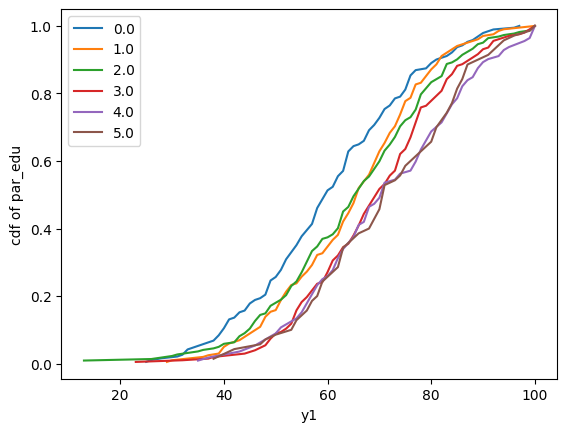

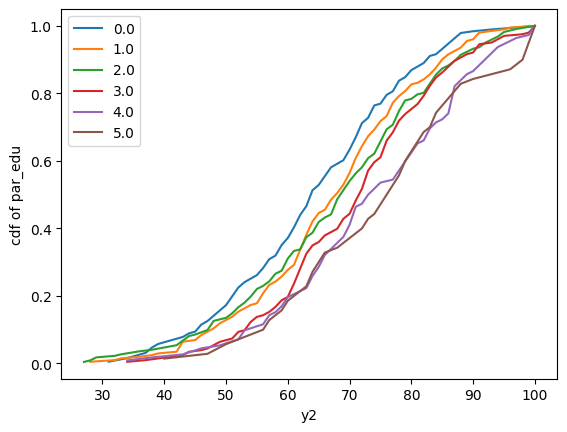

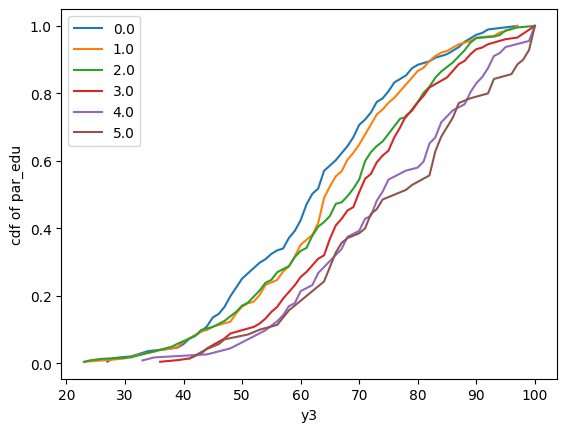

In [7]:
from empiricaldist import Cdf

def display_cdfs(data:pd.DataFrame, y:str, feat:list, feat_values:list=None):
    if feat_values is None:
        feat_values = np.unique(data[feat])
    
    for v in feat_values:
        d = data[data[feat] == v][y]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=v)

    plt.legend()
    plt.xlabel(f'{y}')
    plt.ylabel(f'cdf of {feat}')
    plt.show()   

def compare_cdfs(data:pd.DataFrame, ys:list, features:list, feat_values:dict=None):
    if feat_values is None:
        feat_values = {}
    
    for y in ys:
        for f in features:
            if f in feat_values:
                display_cdfs(data, y, f, feat_values[f])
            else:
                display_cdfs(data, y, f)
                
data[ys] = Y
compare_cdfs(data, ys, ['par_edu'])
# data.drop(columns=ys, inplace=True)

Displaying the CDF of the target variables with respect of the 'par\_edu' feature shows the following trend: the higher the education level of the parents is, the higher the grades generally are: for 'y\_1'(math score): 
* $40\%$ of students whose parents have a Master's degree achieve more than $80$ points 
* Only $15\%$ of students whose parents did not graduate high school achieve the same result.

Additionally, we can notice that the performance of students can be possibly grouped by the presence or absence of a college degree instead of the exact educational level.
 
Let's reinforce this observation with box plots


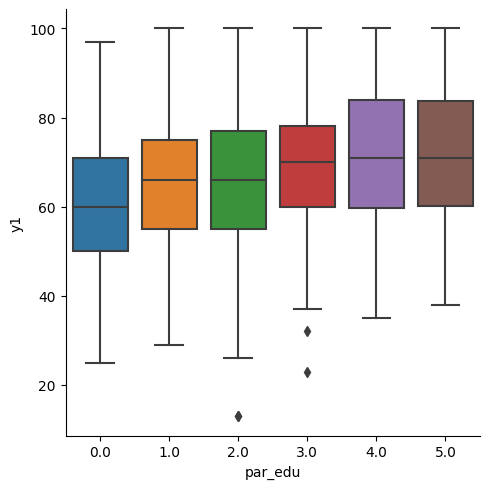

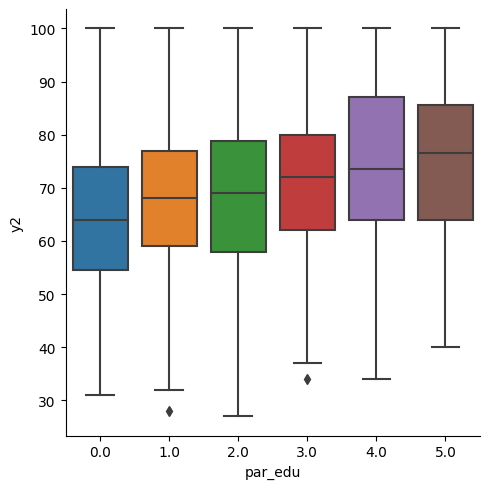

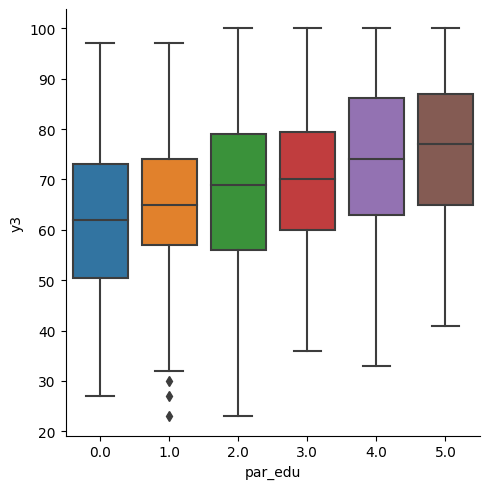

In [8]:
for y in ys:
    sns.catplot(x="par_edu", y=y, 
            data=data,
            kind="box")
# Show plot
plt.show()
data.drop(columns=ys, inplace=True)

The box plots show that across the different scores the students with college-educated students have similar values in the different percentiles: minimum, maximum, median, $25$-th and $75$-th percentiles.  
The next step is to binarize this feature.

In [9]:
from sklearn.preprocessing import Binarizer
collect_binarizer = Binarizer(threshold=2.9)
data[['par_college']] = collect_binarizer.fit_transform(data[['par_edu']]).astype(int)
data.drop(columns='par_edu', inplace=True)

In [10]:
# before applying traget encoding, that data should be split into training and test datasets.
from sklearn.model_selection import train_test_split
df_train, df_test, Y_train, Y_test = train_test_split(data, Y, test_size =0.2, random_state=11)
df = df_train.copy()
assert (df.columns == df_test.columns).all()

In [11]:
# as for preprocessing the race it might be better to use target encoding.
! pip install category_encoders
import category_encoders as ce

In [12]:
def target_encode_multiclass(df_train: pd.DataFrame,Y: pd.DataFrame, feat:str,
                             df_test:pd.DataFrame=None, smoothing:int=None):

    if smoothing is None:
        smoothing = len(df_train) // 25

    target_encoder = ce.TargetEncoder(cols=[feat], smoothing=smoothing)
    new_data = df_train.copy()

    for y in Y.columns:
        new_data[f'{feat}_{y}'] = target_encoder.fit_transform(df_train[feat], Y[y])
    
    # use the exact same values for the test dataset is the parameter is passed
    if df_test is not None:
        new_test = df_test.copy()
        for y in Y.columns:
            y_dict = new_data.loc[:, [f'{feat}_{y}', feat]].groupby([feat])[f'{feat}_{y}'].mean().to_dict() # using the mean will return the value used for the specific rate
            new_test[f'{feat}_{y}'] = new_test[feat].map(y_dict)
                
        return new_data.drop(feat, axis=1), new_test.drop(feat, axis=1)
    
    return new_data.drop(feat, axis=1)

df, df_test = target_encode_multiclass(df, Y_train,'race', df_test)
assert (df.columns == df_test.columns).all()

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [13]:
# def get_Ys(Y, n):
#     return tuple([Y.iloc[:, [i]] for i in range(n)])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_Layer(n_in, n_out):
    return nn.Sequential(
        nn.Linear(in_features=n_in, out_features=n_out), F.relu()
    )

In [37]:
class ANN(nn.Module):
    def __init__(self, input_shape, num_hidden, hidden_units, dropout):
        super(ANN, self).__init__()
        self.input_layer = nn.Linear(input_shape, hidden_units)
        # self.input_layer = nn.Sequential(
        #     nn.Linear(input_shape, hidden_units),
        #     nn.ReLU()
        # )
        hidden = nn.Linear(hidden_units, hidden_units)        
        # hidden = nn.Sequential(
        #     nn.Linear(hidden_units, hidden_units),
        #     nn.ReLU()
        # )
        
        self.hidden_layers = nn.ModuleList([hidden for i in range(num_hidden)])
        
        self.dropout_layer = nn.Dropout(dropout)
        
        self.output_layer = nn.Linear(in_features=hidden_units, out_features=3) 
        
    def forward(self, x):
        # first set the input to the variable x
        x = self.input_layer(x)
        # pass through each hidden layer proceeded with the dropout layer
        for l in self.hidden_layers:
            x = l(x)
            # apply ReLu
            x = F.relu(x)
            x = self.dropout_layer(x)
        return self.output_layer(x)

In [38]:
ann = ANN(3, 4, 128, 0.5)


In [39]:
from torch.utils.data import Dataset, DataLoader

class Task1Dataset(Dataset):
    # expect numpy arrays
    def __init__(self, X:np.array, y: np.array):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [40]:
train_data = Task1Dataset(df.to_numpy(), Y_train.to_numpy())
test_data = Task1Dataset(df_test.to_numpy(), Y_test.to_numpy())

INPUT_SHAPE = train_data[0][0].size(dim=0)
print(INPUT_SHAPE)

7


In [41]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from torch.optim import Adam, SGD, RMSprop

In [44]:
## this function is mostly taken from https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html

BATCH_SIZE = 50
NUM_EPOCHS = 50

def train_cifar(config):

    # first set the model from the values in the config file:
    input_shape = train_data[0][0].size(dim=0)
    
    print(config['num_hidden'])
    print(config['hidden_units'])
    print(config['dropout'])
    
    model = ANN(input_shape=input_shape, num_hidden=config['num_hidden'], 
                hidden_units=config['hidden_units'], dropout=config['dropout'])    

    # set the ANN to a device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    # set the criterion
    criterion = nn.L1Loss()
    # set the optimizer
    
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)

    if config['optimizer'] == 'Adam': 
        optimizer = Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'RMSProp':
        optimizer = RMSprop(model.parameters(), lr=config['lr'], momentum=config['momentum'])
    else:
        optimizer = SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])


    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        
    test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)

    for _ in range(NUM_EPOCHS):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for _, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1

        # Validation loss
        test_loss = 0.0
        test_steps = 0
        for _, data in enumerate(test_loader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.cpu().numpy()
                test_steps += 1

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.

        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (test_loss / test_steps)}, checkpoint=checkpoint)
        
        
    print("Finished Training")

In [45]:
conf = {
        "num_hidden": 2.0,
        "hidden_units": 32.0,
        "lr": 0.2,
        "momentum": 0.99,
        "dropout": 0.1,
        "optimizer": 'Adam'
    }

train_cifar(conf)


2.0
32.0
0.1


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
def main(num_samples=200, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "num_hidden": tune.sample_from(lambda _: np.random.randint(1,10)),
        "hidden_units": tune.sample_from(lambda _: 2**np.random.randint(4, 10)),
        "lr": tune.loguniform(1e-5, 1),
        "momentum": tune.sample_from(lambda _: np.random.uniform(0.8,0.999)),
        "dropout": tune.sample_from(lambda _: np.random.uniform(0,0.3)),
        "optimizer": tune.choice(['Adam', 'SGD', 'RMSProp'])
    }

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

main(num_samples=2, max_num_epochs=2, gpus_per_trial=0)

In [ ]:
from torch.optim import Adam, SGD, RMSprop, lr_scheduler
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

## from lab 7
def train_loss(model, device, train_loader, optimizer,criterion):
    model.train()
    epoch_loss = 0
    for _, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # predictions and error computation
        output = model(data)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss.item() / len(train_loader.dataset) # divide the sum of losses over the number of examples.



## from lab 7
def test_loss( model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)

    return test_loss / len(test_loader.dataset)
    
    
def hyper_tune(parameters=None, train_data=None, test_data=None, epochs=10, batch_size=50):
    use_cuda = torch.cuda.is_available()    
    device = torch.device("cuda" if use_cuda else "cpu")
    # define the model depending on the passed parameters
    input_shape = train_data[0][0].size(dim=0)
    model = ANN(input_shape=input_shape, num_hidden=parameters['num_hidden'], 
                hidden_units=parameters['hidden_units'], dropout=parameters['dropout'])    
    model.to(device)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    criterion = nn.MSELoss()
    
    # determine which optimizer to use
    if parameters['optimizer'] == 'Adam': 
        optimizer = Adam(model.parameters(), lr=parameters['lr'])
    elif parameters['optimizer'] == 'RMSProp':
        optimizer = RMSprop(model.parameters(), lr=parameters['lr'], momentum=parameters['momentum'])
    else:
        optimizer = SGD(model.parameters(), lr=parameters['lr'], momentum=parameters['momentum'])
     
    schedular = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', verbose=True)    
    
    val_history = []
    best_loss = np.inf
    
    for _ in range(epochs):
        for phase in ['train', 'test']:          
            if phase == 'train':
                train_loss(model, device, train_loader, optimizer, criterion)
            elif phase == 'test':
                epoch_loss = test_loss(model, device, test_loader, optimizer, criterion)
            
            if phase == 'test':
                best_loss = min(epoch_loss, best_loss)
                val_history.append(epoch_loss)
            
            if phase == 'train':
                schedular.step(epoch_loss)
    
    tune.report(loss=best_loss)


In [ ]:
from functools import partial
reporter = CLIReporter(
    metric_columns=["loss"])

parameters = {
    "num_hidden": tune.sample_from(lambda _: np.random.randint(1,10)),
    "hidden_units": tune.sample_from(lambda _: 2**np.random.randint(4, 10)),
    "lr": tune.loguniform(1e-5, 1e-1),
    "momentum": tune.sample_from(lambda _: np.random.uniform(0.8,0.999)),
    "dropout": tune.sample_from(lambda _: np.random.uniform(0,0.3)),
    "optimizer": tune.choice(['Adam', 'SGD', 'RMSProp'])
}


result = tune.run(
    partial(hyper_tune, train_data=train_data, test_data=test_data, epochs=10, batch_size=50),
    config=parameters,
    num_samples=100,
    progress_reporter=reporter
)

best_trial = result.get_best_trial("loss")
print(f"Best parameters : {best_trial.config}")
print(f"Best test loss: {best_trial.last_result['loss']}")

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

## Taks2
### subtask 1: adapt the ANN from first task

### subtask 2: Data loading, preprocessing and augmentation 

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. What data augmentation techniques did you use?
    - *Answer*
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *Answer*

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [ ]:
# TODO: Implement task 3

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*
3. What is ensemble learning? What are its pros and cons?
    - *Answer*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [ ]:
# TODO: Implement task 4


### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*